A multi-layer perceptron approach to predicting coordinates of street view images. Must generate image embeddings before running. 

In [1]:
import os
import pandas as pd
import random
from PIL import Image
import numpy as np
from tqdm import tqdm
import requests
from transformers import CLIPProcessor, CLIPModel
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torch.utils.data import random_split
import torch
import dask.dataframe as dd
import io
import folium
from matplotlib import pyplot as plt

/Users/mdanenhower/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
coords = pd.read_csv('coordinates.csv')
image_feats = np.load('image_embeddings.npy')

# will use later for normalizing coordinate inputs
lat_min = coords["latitude"].min()
lat_max = coords["latitude"].max()
lon_min = coords["longitude"].min()
lon_max = coords["longitude"].max()

In [3]:
# functions to normalize/denormalize coordinates to [0,1]

def normalize_coords(lat,lon):
    # Normalize to [0, 1]
    lat_norm = (lat - lat_min) / (lat_max - lat_min)
    lon_norm = (lon - lon_min) / (lon_max - lon_min)

    return lat_norm,lon_norm

def denormalize_coords(lat_norm,lon_norm):
    # If [0, 1] normalization
    lat = lat_norm * (lat_max - lat_min) + lat_min
    lon = lon_norm * (lon_max - lon_min) + lon_min

    return lat,lon

In [4]:
class StreetviewEmbeddingsDataset(Dataset):
    '''
    Dataset of streetview image StreetCLIP embeddings and corresponding coordinates
    '''
    def __init__(self, embeddings_path, coords):
        self.embeddings_path = embeddings_path
        self.coords = coords

    def __len__(self):
        return len(self.coords) - 1

    def __getitem__(self, idx):
        # Get target lat/lon
        lat = torch.tensor(self.coords.iloc[idx]["latitude"], dtype=torch.float32)
        lon = torch.tensor(self.coords.iloc[idx]["longitude"], dtype=torch.float32)

        lat_norm,lon_norm = normalize_coords(lat,lon)

        target = torch.stack([lat_norm, lon_norm])

        embedding = self.embeddings_path[idx]
        embedding_tensor = torch.from_numpy(embedding).float()

        return embedding_tensor, target.float()

In [5]:
# initialize the dataset

dataset  = StreetviewEmbeddingsDataset(image_feats, coords)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# define MLP
regressor = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 2),
    nn.Sigmoid()
).to(device)

# haversine loss function
def haversine_loss(pred, true):
    """
    pred and true should be (N, 2) tensors containing [latitude, longitude] in degrees
    Returns: (N,) tensor of distances in kilometers
    """

    # Denormalize the predictions
    lat_pred = pred[:, 0] * (lat_max - lat_min) + lat_min
    lon_pred = pred[:, 1] * (lon_max - lon_min) + lon_min

    # Stack to form the denormalized predictions
    denormalized_prediction = torch.stack([lat_pred, lon_pred], dim=1)

    # Denormalize the ground truth
    lat_true = true[:, 0] * (lat_max - lat_min) + lat_min
    lon_true = true[:, 1] * (lon_max - lon_min) + lon_min

    # Stack to form the ground truth
    denormalized_truth = torch.stack([lat_true, lon_true], dim=1)


    # calculate haversine distance
    R = 6371.0  # Earth radius in km

    pred_rad = torch.deg2rad(denormalized_prediction)
    true_rad = torch.deg2rad(denormalized_truth)

    dlat = pred_rad[:, 0] - true_rad[:, 0]
    dlon = pred_rad[:, 1] - true_rad[:, 1]

    a = torch.sin(dlat / 2) ** 2 + \
        torch.cos(true_rad[:, 0]) * torch.cos(pred_rad[:, 0]) * torch.sin(dlon / 2) ** 2

    c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
    distance = R * c

    return distance.mean()

# define hyper parameters
opt = torch.optim.Adam(regressor.parameters(), lr=1e-4)
MSEloss = nn.MSELoss()

In [7]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()

    opt.zero_grad()                    # Flush memory
    batch_loss = loss_fn(model(x), y)  # Compute loss
    batch_loss.backward()              # Compute gradients
    opt.step()                         # Make a GD step

    return batch_loss.detach().cpu().numpy()

In [8]:
# train MLP on image embeddings
n_epochs = 25

for epoch in range(n_epochs):
    print(f"Running epoch {epoch + 1} of {n_epochs}")

    epoch_losses = []

    # train
    for batch in loader:
        x, y = batch
        batch_loss = train_batch(x, y, regressor, opt, haversine_loss) # using Haversine loss, can also use MSELoss
        epoch_losses.append(batch_loss)
    epoch_loss = np.mean(epoch_losses)

    print('loss (km)',epoch_loss)

Running epoch 1 of 25
loss (km) 3530.1128
Running epoch 2 of 25
loss (km) 2086.3704
Running epoch 3 of 25
loss (km) 1823.7516
Running epoch 4 of 25
loss (km) 1661.2935
Running epoch 5 of 25
loss (km) 1546.3436
Running epoch 6 of 25
loss (km) 1468.1759
Running epoch 7 of 25
loss (km) 1407.891
Running epoch 8 of 25
loss (km) 1359.9984
Running epoch 9 of 25
loss (km) 1317.3033
Running epoch 10 of 25
loss (km) 1280.7152
Running epoch 11 of 25
loss (km) 1254.8948
Running epoch 12 of 25
loss (km) 1228.9984
Running epoch 13 of 25
loss (km) 1197.6357
Running epoch 14 of 25
loss (km) 1177.0416
Running epoch 15 of 25
loss (km) 1150.836
Running epoch 16 of 25
loss (km) 1131.9412
Running epoch 17 of 25
loss (km) 1108.5721
Running epoch 18 of 25
loss (km) 1093.4641
Running epoch 19 of 25
loss (km) 1072.4398
Running epoch 20 of 25
loss (km) 1055.3406
Running epoch 21 of 25
loss (km) 1037.6573
Running epoch 22 of 25
loss (km) 1020.6104
Running epoch 23 of 25
loss (km) 1008.84283
Running epoch 24 of 2

In [ ]:
# access HuggingFace streetview dataset to test MLP coordinate predictions
# https://huggingface.co/datasets/stochastic/random_streetview_images_pano_v0.0.2

test_images = dd.read_parquet("hf://datasets/stochastic/random_streetview_images_pano_v0.0.2/data/train-*-of-*.parquet")
row0 = test_images.head(1000)  # returns a Pandas DataFrame with the first 1000 images

In [10]:
# set up StreetCLIP model to test new images with

street_clip_model = CLIPModel.from_pretrained("geolocal/StreetCLIP").to(device)
street_clip_processor = CLIPProcessor.from_pretrained("geolocal/StreetCLIP")

def embed_image(byte_encoding):
    '''
    Generate an image embedding using StreetCLIP. Uses the images byte encoding

    args: the image byte encoding
    returns: a tensor of the image embedding
    '''
    # Load image
    image = Image.open(io.BytesIO(byte_encoding)).convert('RGB')

    # Process image
    inputs = street_clip_processor(images=image, return_tensors="pt", padding=True)
    for k in inputs:
        inputs[k] = inputs[k].to(device)

    with torch.no_grad():
        image_feat = street_clip_model.get_image_features(**inputs)
        image_feat = image_feat / image_feat.norm(dim=-1, keepdim=True)

    return image_feat.squeeze(0)

def haversine_distance_single_pair(true_lat, true_lon, pred_lat, pred_lon):
    '''
    Computes haversine distance between two points, use for testing one pair of points
    
    Parameters:
    - true_lat, true_lon: float (degrees)
    - pred_lat, pred_lon: float (degrees)
    
    Returns:
    - distance in kilometers (float)
    '''
    R = 6371.0  # Earth radius in km

    # Convert degrees to radians
    true_lat_rad = np.deg2rad(true_lat)
    true_lon_rad = np.deg2rad(true_lon)
    pred_lat_rad = np.deg2rad(pred_lat)
    pred_lon_rad = np.deg2rad(pred_lon)

    # Differences
    dlat = pred_lat_rad - true_lat_rad
    dlon = pred_lon_rad - true_lon_rad

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(true_lat_rad) * np.cos(pred_lat_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


pred coords 49.39122 6.646103
true coords 50.4480935 6.1795635
error (km) 122.17295799411768


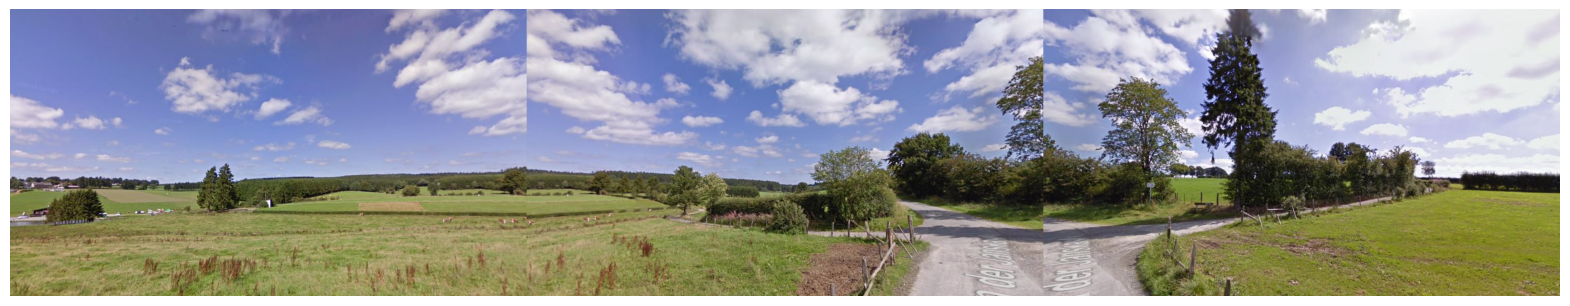

In [ ]:
# test the MLP prediction

# select a random image
rand = random.randint(0,999)

# parse HuggingFace dataset
true_lat = row0.iloc[rand]['latitude']
true_lon = row0.iloc[rand]['longitude']
img = row0.iloc[rand]['image'] # image is stored as a byte encoding
address = row0.iloc[rand]['address']

# generate image embedding
embedding = embed_image(img['bytes'])

# run regressor
pred_coords = regressor(embedding)
pred_lat,pred_lon = denormalize_coords(pred_coords[0],pred_coords[1])
pred_lat = pred_lat.detach().numpy()
pred_lon = pred_lon.detach().numpy()

# create map
m = folium.Map(location=(true_lat, true_lon))

# add ground truth coordinates
folium.Marker(
    [true_lat, true_lon],
    popup="Ground Truth",
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(m)

# add predicted coordinates
folium.Marker(
    [pred_lat, pred_lon],
    popup="Prediction",
    icon=folium.Icon(color='red', icon='info-sign')
).add_to(m)

print('pred coords',pred_lat,pred_lon)
print('true coords',true_lat,true_lon)

print('error (km)', haversine_distance_single_pair(float(true_lat), float(true_lon), pred_lat, pred_lon))

# open image in a new window
streetview = Image.open(io.BytesIO(img['bytes'])).convert('RGB')
plt.figure(figsize=(20, 10))
plt.imshow(streetview)
plt.axis('off')  # Hide the axes
plt.show()

# display map
m

In [12]:
# test regressor on 10 random images from HuggingFace streetview dataset

total_error = np.zeros(10)

for i in range(10):
    rand = random.randint(0,999)

    # parse HuggingFace dataset
    true_lat = row0.iloc[rand]['latitude']
    true_lon = row0.iloc[rand]['longitude']
    img = row0.iloc[rand]['image'] # image is stored as a byte encoding
    address = row0.iloc[rand]['address']

    # generate image embedding
    embedding = embed_image(img['bytes'])

    # run KNN 
    pred_coords = regressor(embedding)
    pred_lat,pred_lon = denormalize_coords(pred_coords[0],pred_coords[1])
    pred_lat = pred_lat.detach().numpy()
    pred_lon = pred_lon.detach().numpy()

    print('pred',pred_lat,pred_lon)
    print('true',true_lat, true_lon)
    error = haversine_distance_single_pair(float(true_lat), float(true_lon),pred_lat,pred_lon)
    total_error[i] = error
    print('error (km)',error)
    print('--------------')

print('average error (km)', np.mean(total_error))

pred -28.16431 -64.21701
true -5.1698882 -80.6520252
error (km) 3090.0240069583047
--------------
pred 51.2082 10.149033
true 52.2151876 5.0241849
error (km) 370.32871877681333
--------------
pred 43.281326 5.1820526
true 42.5258126 1.5662816
error (km) 306.22438831578165
--------------
pred 32.07746 26.98436
true 31.0840681 35.0398088
error (km) 770.8332025750818
--------------
pred 0.9854431 53.224167
true -25.9561855 31.247268
error (km) 3813.482104994127
--------------
pred 47.143494 12.871735
true 46.1288348 14.5949766
error (km) 173.31223878103768
--------------
pred -33.770287 148.9055
true -44.7279311 171.0171819
error (km) 2249.1121555684817
--------------
pred 4.9625587 112.63762
true 6.3986972 116.5388929
error (km) 460.25080440392486
--------------
pred 15.580467 105.49794
true 22.2783426 114.1747987
error (km) 1177.3481892904383
--------------
pred 55.12258 -26.983505
true 63.8473024 -22.3792602
error (km) 1003.729453106151
--------------
average error (km) 1341.4645262770